## 1.3 Compute 'regular shape' object orientation using Contour Analysis

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("OpenCV version: " + cv2.__version__)

### Using Contour Minimum Rectangle Area (`cv2.minAreaRect(contour)`)
- The function `cv2.minAreaRect(contour)` **finds the minimum-area bounding rectangle** that **encloses a given contour**. 
- This rectangle may be **rotated** to fit the shape more efficiently.
    
    ```python
    rect = cv2.minAreaRect(contour)

- The rotation angle depends on the rectangle's aspect ratio:
    - **If `width > height`** → The angle represents the **rotation from the horizontal axis**.
    - **If `width < height`** → The angle represents the **rotation from the vertical axis**.


C:\Users\yunus\AppData\Local\Temp\ipykernel_20284\1803451207.py:20: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


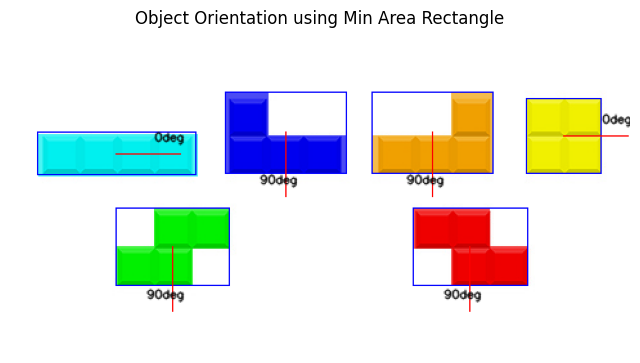

In [27]:
# Load and convert the image to grayscale
image = cv2.imread("blocks.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 1: Apply simple Binary Thresholding (Inverse Binary Thresholding), since the background is white we use cv2.THRESH_BINARY_INV
_, binary = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY_INV)

# Step 2: Apply Canny Edge Detection
edges = cv2.Canny(binary, 100, 200)

# Step 3: Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 4: Calculate minimum area bounding rectangle
output = image.copy()
for contour in contours:
    # Compute minimum area bounding rectangle
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # Draw rectangle
    cv2.drawContours(output, [box], 0, (255, 0, 0), 1)

    # Get center and angle from rotated rectangle
    center = (int(rect[0][0]), int(rect[0][1]))
    angle = rect[2]

    # Draw orientation line
    length = 50
    angle_rad = np.deg2rad(angle)
    end_x = int(center[0] + length * np.cos(angle_rad))
    end_y = int(center[1] + length * np.sin(angle_rad))
    cv2.line(output, center, (end_x, end_y), (0, 0, 255), 1)

    # Draw angle text near the line
    text_position = (end_x - 20, end_y - 10)
    cv2.putText(output, f"{int(angle)}deg", text_position, cv2.FONT_HERSHEY_SIMPLEX, 
                0.3, (0, 0, 0), 1, cv2.LINE_AA)

# Show results using Matplotlib
plt.figure(figsize=(8, 6))

plt.imshow(output[:,:,::-1])
plt.axis("off")
plt.title("Object Orientation using Min Area Rectangle")

plt.show()


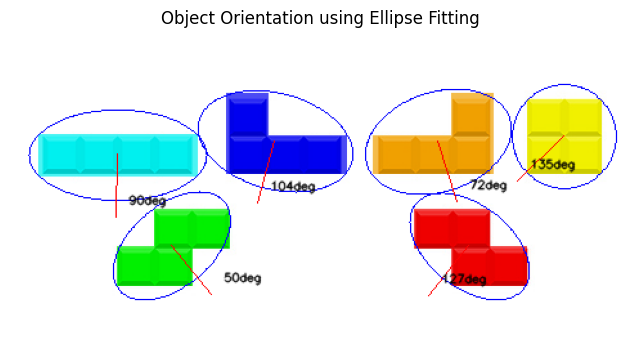

In [39]:
# Load and convert the image to grayscale
image = cv2.imread("blocks.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 1: Apply Binary Thresholding (Inverse)
_, binary = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY_INV)

# Step 2: Apply Canny Edge Detection
edges = cv2.Canny(binary, 100, 200)

# Step 3: Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 4: Fit ellipse and compute orientation
output = image.copy()
for contour in contours:
    if len(contour) >= 5:  # Only fit ellipse if contour has at least 5 points
        ellipse = cv2.fitEllipse(contour)
        cv2.ellipse(output, ellipse, (255, 0, 0), 1)  # Draw ellipse (blue)

        # Get center, axes, and angle
        center = (int(ellipse[0][0]), int(ellipse[0][1]))
        axes = (int(ellipse[1][0] / 2), int(ellipse[1][1] / 2))  # Semi-major and semi-minor axes
        angle = ellipse[2]  # Angle of the major axis

        # Draw orientation line (Major Axis)
        length = 50
        angle_rad = np.deg2rad(angle)
        end_x = int(center[0] + length * np.cos(angle_rad))
        end_y = int(center[1] + length * np.sin(angle_rad))
        cv2.line(output, center, (end_x, end_y), (0, 0, 255), 1)  # Red orientation line

        # Draw angle text near the line
        text_position = (end_x + 10, end_y - 10)
        cv2.putText(output, f"{int(angle)}deg", text_position, cv2.FONT_HERSHEY_SIMPLEX, 
                    0.3, (0, 0, 0), 1, cv2.LINE_AA)

# Show results using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(output[:, :, ::-1])  # Convert BGR to RGB for Matplotlib
plt.axis("off")
plt.title("Object Orientation using Ellipse Fitting")
plt.show()
